In [1]:
# TO CLONE GIT: git clone https://gitlab.com/alexkchew/cluster_tutorial.git
# TO OPEN BY COMMAND LINE: jupyter notebook

## Great info about jupyter notebook
# https://ipython.readthedocs.io/en/stable/install/kernel_install.html#kernels-for-different-environments

## TOOL BOXES THAT YOU MAY NEED:
# HDBSCAN:
#    - Install by: pip install hdbscan
#    - Install by conda: conda install hdbscan or conda install -c conda-forge hdbscan
#    - see reference: https://pypi.org/project/hdbscan/
#    - conda install ipykernel --name Python3 (Rename Python3)
##########################################
### WELCOME TO THE CLUSTERING TUTORIAL ###
##########################################
# PURPOSE: 
'''
This script is designed to teach you how to run MDTraj for analyzing trajectories. 
For this example, we will be looking at a 4 nm faceted gold core with hexadecanethiol. 
The idea here is that we are interested in the bundling ligands, 
which are ligands that are pointing the same direction with their tails close together
'''

# Written by: Alex K. Chew
# Created on: 10/31/2018

## IMPORTING GENERAL TOOLS
import sys
import os
import time

## IMPORTING MATH TOOLS
import numpy as np

## PLOTTING TOOLS
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # For 3D axes

## PRINTING PYTHON VERSION
print(sys.version)
import hdbscan # Comment this out if you do not have hdbscan

3.5.4 |Continuum Analytics, Inc.| (default, Aug 14 2017, 12:43:10) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]


In [2]:
## START BY LOADING THE DATA
# NOTE: We normally use MDTraj to load the data. As a work around, I have used md.traj to extract trajectory information,
# then saved the information in a form of a pickle

## IMPORTING PICKLE
import pickle

## DEFINING LOCATION OF THE PICKLE (Assuming you have opened jupyter notebook here)
pickle_location=os.getcwd()

## DEFINING PICKLE INFORMATION
pickle_name="traj_last_frame.pickle"

## DEFINING FULL PATH
pickle_path = pickle_location + '/' + pickle_name

## LOADING THE DATA
with open(pickle_path,'rb') as f:
    atom_positions,residue_atom_list,box_dimensions  = pickle.load(f) # 


In [3]:
## PRINTING INFORMATION
print("--- atom_positions ---")
print(atom_positions)
print("Total atoms: %d"%(len(atom_positions[0])) )

print("\n--- residue_atom_list ---")
print(residue_atom_list[0:20])
print("...")
print(residue_atom_list[-10:-1])
print("Length: %d"%(len(residue_atom_list)) )

print("\n--- box_dimensions (nm) ---")
print(box_dimensions)

--- atom_positions ---
[[[ 6.0260005   5.87100029  4.27600002]
  [ 6.14900017  5.76900005  4.18900013]
  [ 6.10700035  5.73100042  4.09300041]
  ..., 
  [ 4.48300028  3.7670002   4.60500002]
  [ 4.5         4.375       6.11300039]
  [ 4.31700039  3.42600012  4.55100012]]]
Total atoms: 11835

--- residue_atom_list ---
[['HED', 'S1', 'S'], ['HED', 'C2', 'C'], ['HED', 'H3', 'H'], ['HED', 'H4', 'H'], ['HED', 'C5', 'C'], ['HED', 'H6', 'H'], ['HED', 'H7', 'H'], ['HED', 'C8', 'C'], ['HED', 'H9', 'H'], ['HED', 'H10', 'H'], ['HED', 'C11', 'C'], ['HED', 'H12', 'H'], ['HED', 'H13', 'H'], ['HED', 'C14', 'C'], ['HED', 'H15', 'H'], ['HED', 'H16', 'H'], ['HED', 'C17', 'C'], ['HED', 'H18', 'H'], ['HED', 'H19', 'H'], ['HED', 'C20', 'C']]
...
[['HED', 'Au', 'Au'], ['HED', 'Au', 'Au'], ['HED', 'Au', 'Au'], ['HED', 'Au', 'Au'], ['HED', 'Au', 'Au'], ['HED', 'Au', 'Au'], ['HED', 'Au', 'Au'], ['HED', 'Au', 'Au'], ['HED', 'Au', 'Au']]
Length: 11835

--- box_dimensions (nm) ---
[[ 9.53887367  9.53887367  9.538

In [4]:
## LABELING INFORMATION

## FINDING ALL SULFUR HEAD GROUPS
sulfur_head_group_index_list = np.array([ idx for idx, each_residue in enumerate(residue_atom_list) 
                                             if each_residue[1] == "S1" ])

print("\n---sulfur_head_group_index_list---")
print(sulfur_head_group_index_list[0:10])

## FINDING ALL GOLD ATOM INDEX
gold_atom_index_list = np.array([ idx for idx, each_residue in enumerate(residue_atom_list) 
                                     if each_residue[2] == "Au" ])
print("\n---gold_atom_index_array---")
print(gold_atom_index_list[0:10])


---sulfur_head_group_index_list---
[  0  50 100 150 200 250 300 350 400 450]

---gold_atom_index_array---
[10850 10851 10852 10853 10854 10855 10856 10857 10858 10859]


In [5]:
## LIGAND ATOM INDEX
ligand_atom_index_list = []

## LOOPING THROUGH RESIDUE NAME LIST
for idx,sulfur_head_group_index in enumerate(sulfur_head_group_index_list):
    ## APPENDING FIRST ATOM INDEX
    ligand_atom_index = [sulfur_head_group_index]
    ## DEFINING NEXT ATOM
    next_atom_index = sulfur_head_group_index + 1
    ## DEFINING NEXT SULFUR ATOM INDEX
    try:
        next_sulfur_atom_index = sulfur_head_group_index_list[idx+1]
    except:
        next_sulfur_atom_index = len(residue_atom_list)
    ## USING WHILE LOOP TO CAPTURE INFORMATION
    while next_atom_index != next_sulfur_atom_index and residue_atom_list[next_atom_index][2] != 'Au':
        ## APPENDING
        ligand_atom_index.append(next_atom_index)
        ## ADDING TO NEXT ATOM
        next_atom_index+=1
        # print(next_atom_index)
    
    ## AT THE END, APPEND LIGAND ATOM INDEX
    ligand_atom_index_list.append(ligand_atom_index)
    
## CONVERTING TO NUMPY ARRAY
ligand_atom_index_list = np.array(ligand_atom_index_list)
print(ligand_atom_index_list)
print(ligand_atom_index_list.shape)

[[    0     1     2 ...,    47    48    49]
 [   50    51    52 ...,    97    98    99]
 [  100   101   102 ...,   147   148   149]
 ..., 
 [10700 10701 10702 ..., 10747 10748 10749]
 [10750 10751 10752 ..., 10797 10798 10799]
 [10800 10801 10802 ..., 10847 10848 10849]]
(217, 50)


In [6]:
## LIGAND HEAVY ATOM INDEX
ligand_heavy_atom_index_list = []

## LOOPING THROUGH EACH LIGAND LIST
for each_ligand_atom_index_list in ligand_atom_index_list:
    ligand_heavy_atom_index_list.append( [ each_atom_idx for each_atom_idx in each_ligand_atom_index_list 
                                          if residue_atom_list[each_atom_idx][2] != 'H']  )

## CONVERTING TO NP ARRAY
ligand_heavy_atom_index_list = np.array(ligand_heavy_atom_index_list)
print(ligand_heavy_atom_index_list)
print(ligand_heavy_atom_index_list.shape)
# print(ligand_heavy_atom_index_list[:,1:]) # <-- without sulfur head groups

[[    0     1     4 ...,    40    43    46]
 [   50    51    54 ...,    90    93    96]
 [  100   101   104 ...,   140   143   146]
 ..., 
 [10700 10701 10704 ..., 10740 10743 10746]
 [10750 10751 10754 ..., 10790 10793 10796]
 [10800 10801 10804 ..., 10840 10843 10846]]
(217, 17)


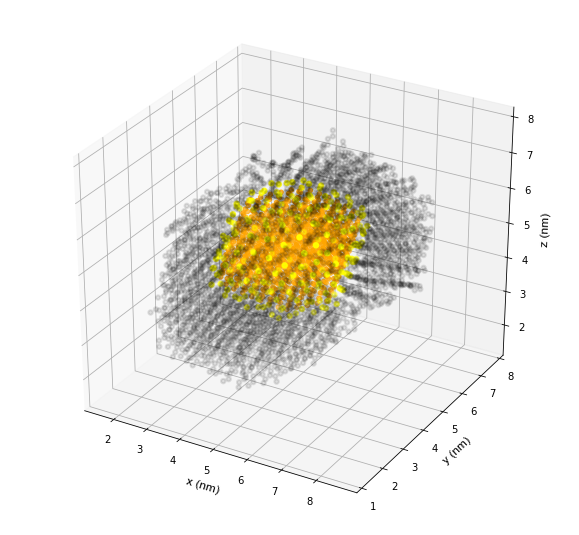

In [7]:
## DEFINING GLOBAL PLOTTING VARIABLES
FONT_SIZE=12
FONT_NAME="Arial" 

LABELS = {
            'fontname': FONT_NAME,
            'fontsize': FONT_SIZE
            }

## DEFAULT FIGURE SIZE
plt.rcParams['figure.figsize'] = [10, 10] # inches
plt.rcParams.update()
### FUNCTION TO PLOT SCATTER
def plot_scatter( positions, frame, atom_index, fig = None, ax = None, **plot_dicts  ):
    '''
    The purpose of this function is to plot the system.
    INPUTS:
        positions: [np.array, shape=(n_frames, n_atoms, 3)]
            atomic positions of your system
        frame: [int]
            frame that you want to plot
        atom_index: [np.array, shape=(N_atoms, 1)]
            atom index for the positions
        fig: [obj, default=None]
            figure object
        ax: [obj, default=None]
            axis object
        plot_dicts: [dict]
            plotting dictionary
    OUTPUTS:
        fig: [obj, default=None]
            figure object
        ax: [obj, default=None]
            axis object
    '''
    ## IMPORTING TOOLS
    # import matplotlib.pyplot as plt
    # from mpl_toolkits.mplot3d import Axes3D # For 3D axes
    
    ## CREATING FIGURE
    if fig == None or ax == None:
        fig = plt.figure(); ax = fig.add_subplot(111, projection='3d', aspect='equal')
    
        ## ADDING X, Y, Z LABELS
        ax.set_xlabel('x (nm)', **LABELS)
        ax.set_ylabel('y (nm)', **LABELS)
        ax.set_zlabel('z (nm)', **LABELS)

    ## PLOTTING POINTS
    ax.scatter(positions[frame][atom_index, 0], positions[frame][atom_index, 1], positions[frame][atom_index, 2], 
                   **plot_dicts )
    
    return fig, ax


### FUNCTION TO PLOT EACH ATOM INDEX
def plot_each_atom_index( positions, frame, plot_atom_index_dict, plot_order ):
    '''
    This function plots each atom index consecutively
    INPUTS:
        positions: [np.array, shape=(n_frames, n_atoms, 3)]
            atomic positions of your system
        frame: [int]
            frame that you want to plot
        plot_atom_index_dict: [dict]
            dictionary containing all atom indices
        plot_order: [list]
            order of how you want to plot
    OUTPUTS:
        fig: [obj, default=None]
            figure object
        ax: [obj, default=None]
            axis object
    '''
    ## DEFING FIGURE AND AXIS
    fig, ax = None, None
    ## LOOPING THROUGH EACH ATOM INDEX
    for each_atom_type in plot_order:
        ## DEFINING ATOM INDEX
        atom_index = plot_atom_index_dict[each_atom_type]['atom_index']
        ## DEFINING PLOTTING INFORMATION
        plot_dicts = plot_atom_index_dict[each_atom_type]['plotting_dict']
        ## PLOTTING SCATTER FUNCTION
        fig, ax = plot_scatter( positions, frame, atom_index = atom_index, fig = fig, ax = ax, **plot_dicts  )
               
    return fig, ax
            
## DEFINING VARIABLES FOR ATOM INDEX
plot_atom_index_dict={
    'LIGAND': { 'atom_index': ligand_heavy_atom_index_list[:,1:].flatten(),
                'plotting_dict': { 'marker': 'o',
                                   'edgecolors': 'black',
                                   'color' : 'black',
                                    'linewidth': 2 ,
                                   'alpha':0.1,
                                  }},
    'AUNP': { 'atom_index': gold_atom_index_list,
                'plotting_dict': { 'marker': 'o',
                                   'edgecolors': 'orange',
                                   'color' : 'orange',
                                   'linewidth': 1 ,
                                  }},
    'SULFURS': { 'atom_index': sulfur_head_group_index_list,
                'plotting_dict': { 'marker': 'o' ,
                                   'edgecolors': 'yellow',
                                   'color' : 'yellow',
                                    'linewidth': 2,
                                  }},
    }
         
## DEFINING PLOTTING ORDER
plot_order = ['AUNP', 'SULFURS','LIGAND'] 
## PLOTITNG EACH               
fig, ax = plot_each_atom_index(positions = atom_positions, 
                                frame = 0,
                                plot_atom_index_dict = plot_atom_index_dict,
                                plot_order = plot_order)

(217,)


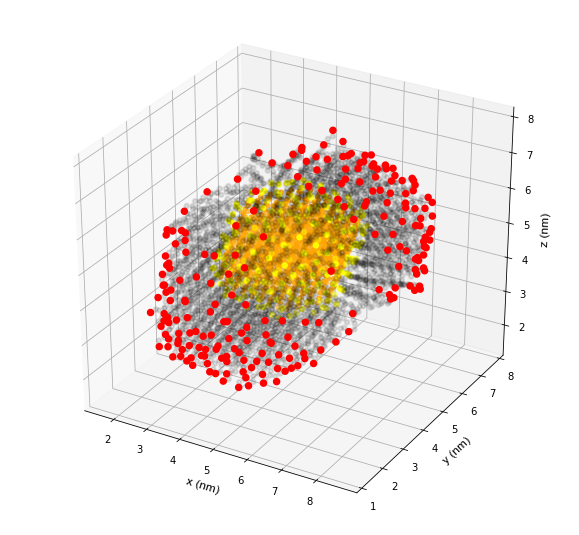

In [8]:
##############################################
######## CALCULATING BUNDLINGS GROUPS ########
##############################################

## START BY FINDING ALL END GROUPS
end_group_index = ligand_heavy_atom_index_list[:,-1]
print(end_group_index.shape)

###########################
### PLOTTING END GROUPS ###
###########################

## ADDING END GROUPS TO PLOTTING DICTIONARY
plot_atom_index_dict['END_GRPS']={ 'atom_index': end_group_index,
                                    'plotting_dict': { 'marker': 'o',
                                                       'edgecolors': 'red',
                                                       'color' : 'red',
                                                        'linewidth': 3 ,
                                                       'alpha':1,
                                                      }}

## PLOTTING END GROUPS
plot_order = ['AUNP', 'SULFURS', 'LIGAND', 'END_GRPS'] 
## PLOTITNG EACH               
fig, ax = plot_each_atom_index(positions = atom_positions, 
                                frame = 0,
                                plot_atom_index_dict = plot_atom_index_dict,
                                plot_order = plot_order)


In [9]:
################################################
### CALCULATING DISTANCES BETWEEN END GROUPS ###
################################################

### FUNCTION TO CALCULATE DISTANCE BETWEEN PAIRS (TAKEN FROM MD.TRAJ)
def calc_dist2_btn_pairs(coordinates, pairs):
    """        
    Distance squared between pairs of points in each coordinate
    INPUTS:
        coordinates: [np.array, shape=(N,3)] 
            atomic coordinates
        pairs: [np.array, shape=(M x 2)]
            atom pairs that you are interested in
    OUTPUTS:
        distances: distances in the form of a M x 1 array
    """
    delta = np.diff(coordinates[pairs], axis=1)[:, 0]
    return (delta ** 2.).sum(-1) ** 0.5 
## CALCULATING TAIL-TAIL DISTANCES

### FUNCTION TO CREATE ATOM PAIRS WITH SELF ATOMS, SUCH AS GOLD-GOLD, OR ANY OTHER STRUCTURAL OBJECTS
def create_atom_pairs_with_self(indices):
    '''
    The purpose of this script is to create atom pairs for a set of atoms with itself. For example, you may want the atom indices of gold atoms to gold atoms, but do not want the distance calculations to repeat.
    This script is useful for those interested in generating atom pairs for a list with itself.
    INPUTS:
        indices: [np.array, shape=(num_atoms, 1)] Index of the atoms
    OUTPUTS:
        atom_pairs: [np.array, shape=(N_pairs,2)] atom pairs when varying indices, but NO repeats!
        e.g.: Suppose you had atoms [0, 1, 2], then the list will be:
            [[0, 1],
             [0, 2],
             [1, 2]]
            NOTE: There are no repeats in the atom indices here! In addition, an atom cannot interact with itself!
        upper_triangular: [np.array] indices of the upper triangular matrix, which you can use to create matrix
    '''
    ## FINDING NUMBER OF ATOMS
    num_atoms = len(indices)
    
    ## DEFINING A UPPER TRIANGLAR MATRIX
    upper_triangular = np.triu_indices(num_atoms, k = 1)
    
    ## FINDING ATOM INDICES
    atom_indices = np.array(upper_triangular).T

    ## CORRECTING ATOM INDICES BASED ON INPUT ATOM INDEX
    atom_pairs = indices[atom_indices]
    
    return atom_pairs, upper_triangular

### FUNCTION TO CALCULATE SELF DISTANCES FOR A SINGLE FRAME
def calc_pair_distances_with_self_single_frame( positions, atom_index, frame=0 ):
    '''
    The purpose of this function is to calculate distances between atom indices of itself.
    NOTE: This does not take into account PBC's -- if so, use MDTraj's version.
    INPUTS:
        positions: [np.array, shape=(time,N,3)]
            positions as a function of time
        atom_index: [np.array, shape=(M,1)]
            atom indices that you are computing distances for
        frame: [int, default=0]
            frame that you are interested in calculating pair distances for
    OUTPUTS:
        distances_matrix: [np.array, shape=(N, N)]
            distance matrix for a single frame
    '''
    ## GENERATING ATOM PAIRS BETWEEN END GROUP INDEXES
    atom_pairs, upper_triangular_indices = create_atom_pairs_with_self( indices = atom_index,
                                       )

    ## CALCULATING DISTANCES
    distances = calc_dist2_btn_pairs( coordinates = positions[frame],
                                      pairs       = atom_pairs,
                                    )

    ## DEFINING NUMBER OF ATOMS
    num_atoms = len(atom_index)

    ## CREATING DISTANCE MATRIX
    distances_matrix = np.zeros( (num_atoms, num_atoms)  )

    ## FILLING DISTANCE MATRIX
    distances_matrix[upper_triangular_indices] = distances

    return distances_matrix

########################################################################################

## FINDING DISTANCES BETWEEN PAIRS
distances_matrix = calc_pair_distances_with_self_single_frame( positions = atom_positions,
                                                              atom_index = end_group_index,
                                                              frame = 0
                                                            ) # N x N distance array (upper triangular)

## ADJUSTING FOR SYMMETRIC DISTANCES
distances_matrix = distances_matrix + distances_matrix.T

## PRINTING DISTANCE MATRIX
print(distances_matrix)


[[ 0.          4.62768459  4.26592875 ...,  6.55813122  6.49252939
   6.32729864]
 [ 4.62768459  0.          0.45020211 ...,  4.19759607  3.53414631
   4.96785307]
 [ 4.26592875  0.45020211  0.         ...,  4.09406519  3.67333913
   4.86377096]
 ..., 
 [ 6.55813122  4.19759607  4.09406519 ...,  0.          2.9989841
   2.23047733]
 [ 6.49252939  3.53414631  3.67333913 ...,  2.9989841   0.          2.6519959 ]
 [ 6.32729864  4.96785307  4.86377096 ...,  2.23047733  2.6519959   0.        ]]


In [10]:
### DBSCAN ALGORITHM ###

### FUNCTION TO PRINT THE NUMBER OF CLUSTERS FOR A GIVEN CLUSTER ALGORITHM
def cluster_print_num_cluster(labels):
    '''
    The purpose of this function is to print the number of clusters
    INPUTS:
        labels: [np.array] labels from cluster algorithm, e.g. [ 0, -1, 2, ...]
    OUTPUTS:
        void. We will print the number of labels
    '''
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    print('Estimated number of clusters: %d'%(n_clusters_))
    return n_clusters_

### FUNCTION TO CALCULATE BUNDLING GROUPS USING DBSCAN METHOD
def cluster_DBSCAN( X, eps, min_samples , metric='precomputed', verbose=False):
    '''
    The purpose of this function is to calculate the DBSCAN groups.
    Depreciated name: calc_bundling_groups_DBSCAN
    INPUTS:
        X: [np.array, shape=(N,N) or (N,2)] array of features
        eps: [float] cutoff for distances / neighbors
        min_samples: [int] number of minimum samples to be consiered a group
        metric: [str] metric used to calculate distance. 'precomputed' means that X is already pre-computed and is square
        verbose: [logical] True if you want to print out number of clusters
    OUTPUTS:
        label: [np.array, shape=(num_ligands, 1)] labels of the groups. Note that -1 means it is noisy labels
    '''
    ## IMPORTING SKLEARN MODULES
    from sklearn.cluster import DBSCAN
    ## USING DBSCAN
    db = DBSCAN(eps=eps, min_samples=min_samples, metric=metric).fit(X)
    ## FINDING LABELS FOR DBSCAN
    labels = db.labels_        
    if verbose is True:
        cluster_print_num_cluster(labels)
    return labels

## DEFINING CUTOFF AND MINIMUM NUMBER OF NEIGHBORS
# eps=0.3 # nm <-- try values between 0.3 and 1.0
eps=0.5 # nm <-- try values between 0.3 and 1.0
# eps=1.0 # nm <-- try values between 0.3 and 1.0
min_samples=3

## RUNNING DBSCAN CLUSTERING
labels = cluster_DBSCAN( X = distances_matrix,
                         eps = eps,
                         min_samples = min_samples,
                         metric='precomputed',
                         verbose = False
                        )
print("--- labels ---")
print(labels)

## FINDING UNIQUE ASSIGNEMTS
unique_assignments = np.unique(labels, return_counts=True)[0]

## FINDING TOTAL GROUPS
total_groups = len(unique_assignments)

print("\n--- unique_assignments ---")
print(unique_assignments)
print("Total groups: %d"%(total_groups) )


--- labels ---
[ 0  1  1  5  0 -1 -1  2  2 -1  0 -1  3 -1  2 11  0  2 -1  2 -1  4  3 -1  2
 -1  5  6 -1  5 -1 -1  6  2 -1  2  2 -1  5  3  5 -1 11  6 14  7 -1  8 -1 -1
 -1 -1 -1  9  9 -1 15 -1 -1 -1 -1  2 -1 -1  9 -1 -1 -1 -1 -1 10 -1 16  8  0
 -1  0  0  8 11 -1 12 12 13 11 15 19  4 11 -1 14 -1 -1 -1 11  4 11 14 11 12
 15 11 11 -1 -1 -1 -1 16 -1 11 -1  4 11 12 11  7  7  8 17 -1 -1 -1  8 -1  8
 18  9 -1  8 -1 17  7 -1 -1 -1 -1  7  7 -1  7  7 19  7 20  7  3  1  3  7  7
 12  7  3  7  2 20  7  7 20 -1  7 19 19 19 -1  7 19 -1  7 10 10 -1 10 16 -1
 -1 -1 19 18  4 19 10 10 10 19 11 13 19 -1 22 21 -1 -1 -1 -1 -1 22 -1 -1 19
 13 -1  5 19 -1 -1 19 10 -1 18 17 21 22 -1 21 10 -1]

--- unique_assignments ---
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Total groups: 24


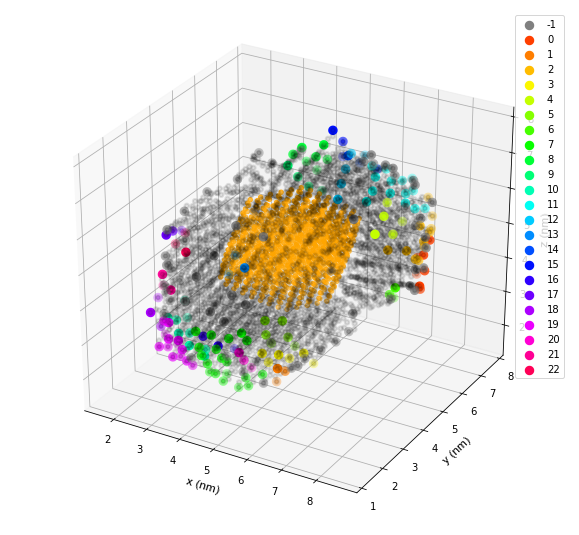

In [11]:
### FUNCTION TO GET CMAP
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.
    This function is useful to generate colors between red and purple without having to specify the specific colors
    USAGE:
        ## GENERATE CMAP
        cmap = get_cmap(  len(self_assembly_coord.gold_facet_groups) )
        ## SPECIFYING THE COLOR WITHIN A FOR LOOP
        for ...
            current_group_color = cmap(idx) # colors[idx]
            run plotting functions
    '''
    ## IMPORTING FUNCTIONS
    import matplotlib.pyplot as plt
    return plt.cm.get_cmap(name, n + 1)
    
### FUNCTION TO FIND GROUP ASSIGNMENTS
def find_group_assignments( assignments ):
    '''
    The purpose of this function is to find the group assignments with a given array of assignments.
    For example, suppose you are given a list of numbers [ 0 , 1 ,2, 0 ], and you want to create a new list:
        0: [0, 3]
        1: [1]
        2: [2]
    In this case, we are generating list of lists to get all the indexes that are matching
    INPUTS:
        assignments: [np.array, shape=(N,1)] assignments for each index
    OUTPUTS:
        group_list: [dict] dictionary of the group list
    '''
    ## FINDING UNIQUE ASSIGNMENTS
    unique_assignments = np.unique( assignments )
    ## CREATING EMPTY DICTIONARY LIST
    group_list = {}    
    ## LOOPING THROUGH EACH ASSIGNMENT AND FINDING ALL INDICES WHERE TRUE
    for each_assignment in unique_assignments:
        ## FINDING ALL INDEXES
        indices_with_assignments = np.where(assignments == each_assignment)[0] # ESCAPING TUPLE
        ## CREATING A DICTIONARY AND STORING THE VALUES
        group_list[str(each_assignment)] = indices_with_assignments
    return group_list
    
## QUICK FUNCTION TO REORDER LIST OF INT
def sort_list_of_int(listofstrings):
    '''This function simply sorts a list of strings'''
    convert_to_int = [ int(each_str) for each_str in listofstrings ]
    sorted_convert_to_int = sorted(convert_to_int)
    convert_to_str = [ str(each_int) for each_int in sorted_convert_to_int ]
    return convert_to_str
    
### FUNCTION TO PLOT ASSIGNMENTS
def plot_assignments( positions, atom_index, frame, group_list, fig = None, ax = None, **plot_dict):
    '''
    The purpose of this function is to plot the assignments for a given frame
    INPUTS:
        positions: [np.array, shape=(n_frames, n_atoms, 3)]
            atomic positions of your system
        frame: [int]
            frame that you want to plot
        atom_index: [np.array, shape=(N_atoms, 1)]
            atom index for the positions
        group_list: [dict]
            group list for the assignments of atom_index
        fig: [obj, default=None]
            figure object
        ax: [obj, default=None]
            axis object
    OUTPUTS:
        fig: [obj, default=None]
            figure object
        ax: [obj, default=None]
            axis object
    '''
    ## GENERATING COLOR LIST
    cmap_colors = get_cmap(n=len(group_list))
    
    ## CONVERTING GROUP LIST TO ORDER CORRECTLY
    group_list_keys_sorted = sort_list_of_int(group_list.keys())
    
    ## PLOTTING ASSIGNMENTS
    for idx, each_group in enumerate(group_list_keys_sorted):

        ## DEFINING  COLOR
        if each_group == '-1':
            current_color = "gray"
        else:
            current_color = cmap_colors(idx)

        ## ADDING TO PLOT
        ax.scatter( positions[frame][end_group_index[group_list[each_group]], 0],
                    positions[frame][end_group_index[group_list[each_group]], 1],
                    positions[frame][end_group_index[group_list[each_group]], 2],
                   color=current_color,
                   label = each_group,
                   **plot_dict
                  )
    ## ADDING LEGEND
    ax.legend()
        
    return fig, ax
###############################################

## FINDING GROUP LIST
group_list = find_group_assignments(labels)

## DEFINING PLOT DICTIONARY FOR ASSIGNMENTS
assignment_plot_dict = {
    'linewidth': 5
}

## PLOTTING END GROUPS
plot_order = ['AUNP', 'LIGAND']  # 'LIGAND' 'SULFURS'
## PLOTTING EACH               
fig, ax = plot_each_atom_index(positions = atom_positions, 
                                frame = 0,
                                plot_atom_index_dict = plot_atom_index_dict,
                                plot_order = plot_order)

## PLOTTING ASSIGNMENTS
fig, ax = plot_assignments( positions = atom_positions,
                           atom_index = end_group_index,
                           group_list = group_list,
                           frame = 0,
                           fig = fig,
                           ax = ax,
                           **assignment_plot_dict
                          )

## PLAY WITH DIFFERENT EPSILON AND NUMBER OF GROUPS HERE

Estimated number of clusters: 2
--- labels ---
[ 0  1  1  1  0  0 -1  0  0 -1  0 -1  1  0  0  0  0  0  0  0  0  0  1  0  0
  1  1  0  0  1  0  0  0  0  0  0  0  0  1  1  1  0  0  0  0  1  0  0  1 -1
  1  1  0  0  0  1  0  1  1  1  0  0 -1 -1  0  1  0  1  1  0  1  0  1  0  0
  0  0  0  0  0  0  0  0  1  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  1  1  1  0  0  0  0  0  0  0  1  1  0  1  1  1  1  0  0  0
  1  0  1  0  0  1  1  1  1  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  0  1  1  1  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  0  1  1  1  1  1  0  1  1  1  1  1  1  1  0  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  0  1  1  1  1  1  1  1  1]

--- unique_assignments ---
[-1  0  1]
Total groups: 3


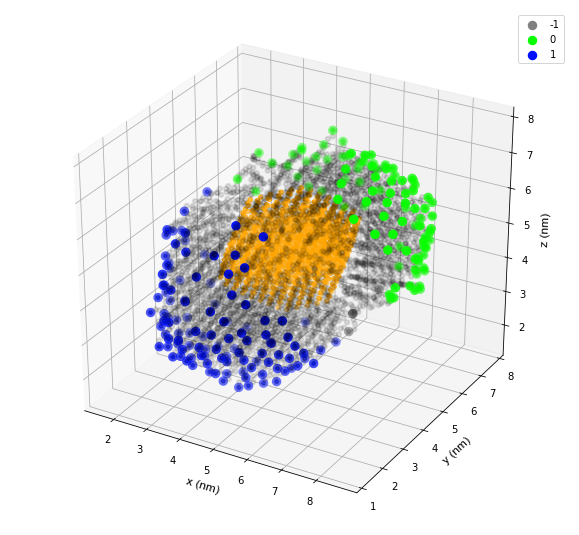

In [12]:
### HDBSCAN ALGORITHM
### FUNCTION TO USE HDBSCAN TO FIND CLUSTERS
def cluster_HDBSCAN(X, min_samples, metric='precomputed', verbose=False):
    '''
    The purpose of this function is to cluster using HDBSCAN using its defaults. 
    INPUTS:
        X: [np.array, shape=(N,N) or (N,2)] array of features
        min_samples: [int] number of minimum samples to be consiered a group
        metric: [str] metric used to calculate distance. 'precomputed' means that X is already pre-computed and is square
        verbose: [logical] True if you want to print out number of clusters
    OUTPUTS:
        label: [np.array, shape=(num_ligands, 1)] labels of the groups. Note that -1 means it is noisy labels
    '''
    ## IMPORTING HDBSCAN
    ## USAGE INFORMATION: http://hdbscan.readthedocs.io/en/latest/basic_hdbscan.html
    import hdbscan
    hdbscan_cluster = hdbscan.HDBSCAN(algorithm='best', 
                                      alpha=1.0, 
                                      approx_min_span_tree = True,
                                      gen_min_span_tree = False,
                                      leaf_size = 40,
                                      min_cluster_size = min_samples,
                                      metric=metric).fit(X)
    labels = hdbscan_cluster.labels_
    if verbose is True:
        cluster_print_num_cluster(labels)
    return labels
    
## DEFINING MINIMUM NUMBER OF SAMPLES
min_samples = 3

## RUNNING DBSCAN CLUSTERING
labels = cluster_HDBSCAN( X = distances_matrix,
                         min_samples = min_samples,
                         metric='precomputed',
                         verbose = True
                        )
print("--- labels ---")
print(labels)

## FINDING UNIQUE ASSIGNEMTS
unique_assignments = np.unique(labels, return_counts=True)[0]

## FINDING TOTAL GROUPS
total_groups = len(unique_assignments)

print("\n--- unique_assignments ---")
print(unique_assignments)
print("Total groups: %d"%(total_groups) )

## PLOTTING HDBSCAN RESULTS
## PLOTTING END GROUPS
plot_order = ['AUNP', 'LIGAND']  # 'LIGAND' 'SULFURS'
## PLOTTING EACH               
fig, ax = plot_each_atom_index(positions = atom_positions, 
                                frame = 0,
                                plot_atom_index_dict = plot_atom_index_dict,
                                plot_order = plot_order)

## FINDING GROUP LIST
group_list = find_group_assignments(labels)

## PLOTTING ASSIGNMENTS
fig, ax = plot_assignments( positions = atom_positions,
                           atom_index = end_group_index,
                           group_list = group_list,
                           frame = 0,
                           fig = fig,
                           ax = ax,
                           **assignment_plot_dict
                          )


In [13]:
### INCLUSION OF ANGLES ###

### FUNCTION TO FIND ALL ANGLES BETWEEN DISPLACEMENT VECTORS
def find_angle_btwn_displacement_vectors( displacements, frame=0 ):
    '''
    The purpose of this function is to find the angle between a list of displacement vectors. It will return a matrix with the angles between each displacement vector.
    ## -- UPDATE: This function clips the values to fall within -1.0 and 1.0
    Note that this function fills the diagonals to be zero in angles, with the assumption that the displacement angle with itself is indeed 0 degrees
    INPUTS:
        displacements: [np.array, shape=(time, N, 3)] 
            N displacement vectors
        frame: [int, default=0]
            frame that you are interested in
    OUTPUTS:
        angles_btwn: [np.array, shape=(N,N)] Angles in degrees between all displacement vectors
    '''
    displacements = displacements[frame].astype('float64')
    ## FINDING NORMS OF DISPLACEMENT
    displacement_norms = np.linalg.norm(displacements, axis = 1)
    ## DEFINING DOT PRODUCTS
    dot_products_matrix = np.dot(displacements, displacements.T) ## SHAPE: num_ligands x num_ligands    
    ## DEFINING NORM MATRIX
    displacement_norms_matrix = np.matmul( displacement_norms[:, np.newaxis], displacement_norms[np.newaxis, :] ).astype('float64')
    ## FINDING THE DOT PRODUCT DIVIDED BY DISPLACEMENTS
    dot_product_over_displacement_matrix = dot_products_matrix / displacement_norms_matrix
    ## FILLING DIAGONALS TO BE 1 <-- REQUIRED TO AVOID NUMERICAL ERRORS WHERE THE DOT PRODUCTS AND DIVISION OF NORMS SLIGHTLY > 1
    # np.fill_diagonal(dot_product_over_displacement_matrix, val=1)
    ## FINDING ARC COSINE OF THE ANGLE
    angles_btwn = np.rad2deg( np.arccos( np.clip(dot_product_over_displacement_matrix, -1.0, 1.0) ) )
    return angles_btwn

## CALCULATING VECTOR DISPLACEMENTS
displacements = atom_positions[:, end_group_index ] -   atom_positions[:, sulfur_head_group_index_list ]

## CALCULATING ANGLES BETWEEN MATRIX
angles_btwn = find_angle_btwn_displacement_vectors(displacements, frame = 0)

## PRINTING
print("--- angles_btwn ---")
print(angles_btwn)


--- angles_btwn ---
[[  0.00000000e+00   9.52594671e+01   9.61579823e+01 ...,   1.11231045e+02
    1.20519364e+02   1.56335945e+02]
 [  9.52594671e+01   0.00000000e+00   7.01191229e+00 ...,   2.85088717e+01
    2.55455967e+01   6.14434432e+01]
 [  9.61579823e+01   7.01191229e+00   0.00000000e+00 ...,   2.25846379e+01
    2.64757451e+01   6.12710689e+01]
 ..., 
 [  1.11231045e+02   2.85088717e+01   2.25846379e+01 ...,   0.00000000e+00
    2.71038683e+01   5.00644105e+01]
 [  1.20519364e+02   2.55455967e+01   2.64757451e+01 ...,   2.71038683e+01
    0.00000000e+00   3.59760567e+01]
 [  1.56335945e+02   6.14434432e+01   6.12710689e+01 ...,   5.00644105e+01
    3.59760567e+01   8.53773646e-07]]


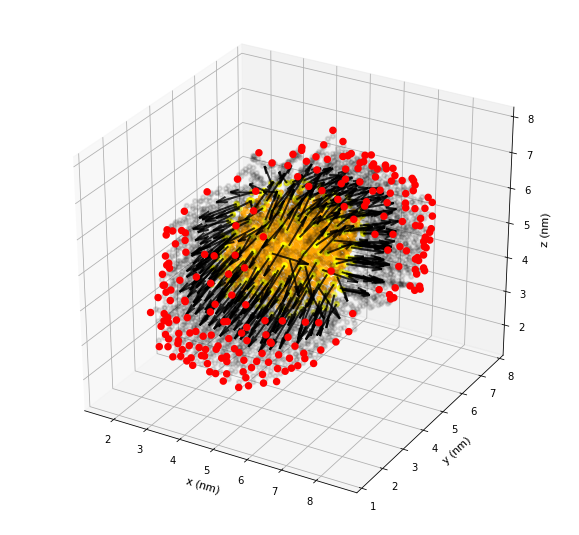

In [14]:
### PLOTTING DISPLACEMENT VECTORS

## PLOTTING END GROUPS
plot_order = ['AUNP', 'SULFURS', 'LIGAND', 'END_GRPS' ]  # 'LIGAND' 'SULFURS' # , 'LIGAND'
## PLOTTING EACH               
fig, ax = plot_each_atom_index(positions = atom_positions, 
                                frame = 0,
                                plot_atom_index_dict = plot_atom_index_dict,
                                plot_order = plot_order)

## DEFINING ORIGIN AND POINTING VECTORS
origin_vectors= atom_positions[0, sulfur_head_group_index_list ]
pointing_vectors =  displacements[0] #  atom_positions[:, end_group_index ] #
## PLOTTING QUIVERS
ax.quiver(origin_vectors[:,0], origin_vectors[:,1], origin_vectors[:,2], pointing_vectors[:,0], pointing_vectors[:,1], pointing_vectors[:,2],
           color = 'k', alpha=.8, length = 1, normalize = True, linewidths = 2) #'black' color = colors,

Estimated number of clusters: 13
--- labels ---
[10  7  7  7 10 11 -1 11 11 -1 10 -1  8 -1 11 12 10 11  4 12 -1  9  8 -1 12
  7  7  4 -1  7 -1 10 -1 11 12 11 11 -1  7  7  7 10 -1  4  3  7  2  2 -1 -1
  7 -1  3  2  2 -1  2 -1  1 -1  2  4 -1 -1  2  7 -1  8 -1  2  7 -1  7  2 11
  2 10 -1  2 12 -1  6 -1 -1 12  2  7  9 12  0 -1  6  3 12 12  9 12 -1 12 -1
  2 12 12  6 -1  7 -1  7  6 12  3  9 12 -1 12  7  7  2  1  1  7 -1  2  0  2
  7  2 -1  2  2  1  7 -1 -1  0 -1  7  7  7  7  7  7  7  7  7  8  7  7  7  7
 -1  7  7  7  9  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7 -1  7  7  8
  7  7  7  7 -1  7  7  7  7  7 12 -1  7 -1  5  7 -1 -1  0  7 -1  5  7  7  7
 -1  7  7  7 -1 -1  7  7 -1  7  1  5  5  5 -1  7  1]

--- unique_assignments ---
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12]
Total groups: 14


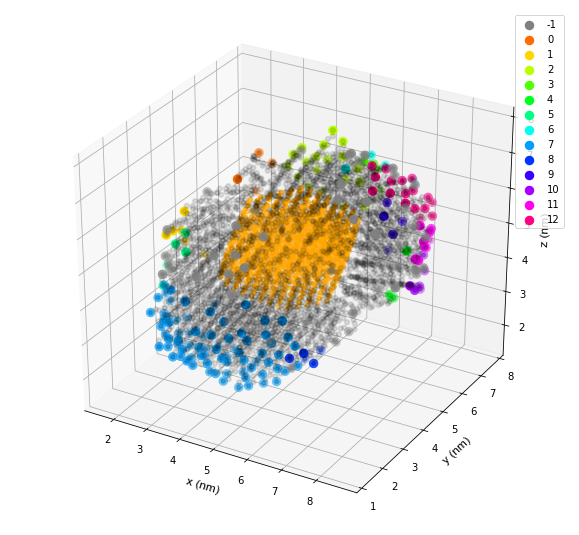

In [15]:
### RUNNING HDBSCAN ALGORITHM FOR JUST ANGLES
## DEFINING MINIMUM NUMBER OF SAMPLES
min_samples = 3

## RUNNING DBSCAN CLUSTERING
labels = cluster_HDBSCAN( X = angles_btwn,
                         min_samples = min_samples,
                         metric='precomputed',
                         verbose = True
                        )
print("--- labels ---")
print(labels)

## FINDING UNIQUE ASSIGNEMTS
unique_assignments = np.unique(labels, return_counts=True)[0]

## FINDING TOTAL GROUPS
total_groups = len(unique_assignments)

print("\n--- unique_assignments ---")
print(unique_assignments)
print("Total groups: %d"%(total_groups) )

## PLOTTING HDBSCAN RESULTS
## PLOTTING END GROUPS
plot_order = ['AUNP', 'LIGAND']  # 'LIGAND' 'SULFURS' # , 'LIGAND'
## PLOTTING EACH               
fig, ax = plot_each_atom_index(positions = atom_positions, 
                                frame = 0,
                                plot_atom_index_dict = plot_atom_index_dict,
                                plot_order = plot_order)

## FINDING GROUP LIST
group_list = find_group_assignments(labels)

## PLOTTING ASSIGNMENTS
fig, ax = plot_assignments( positions = atom_positions,
                           atom_index = end_group_index,
                           group_list = group_list,
                           frame = 0,
                           fig = fig,
                           ax = ax,
                           **assignment_plot_dict
                          )

--- feature_matrix ---
[[  0.00000000e+00   5.69513523e-01   5.48193814e-01 ...,   7.41014971e-01
    7.62518279e-01   8.51213379e-01]
 [  5.69513523e-01   0.00000000e+00   4.91347236e-02 ...,   3.55623438e-01
    3.03704309e-01   4.97897914e-01]
 [  5.48193814e-01   4.91347236e-02   0.00000000e+00 ...,   3.32337087e-01
    3.15454543e-01   4.90566025e-01]
 ..., 
 [  7.41014971e-01   3.55623438e-01   3.32337087e-01 ...,   0.00000000e+00
    2.72801874e-01   2.86036739e-01]
 [  7.62518279e-01   3.03704309e-01   3.15454543e-01 ...,   2.72801874e-01
    0.00000000e+00   2.74622076e-01]
 [  8.51213379e-01   4.97897914e-01   4.90566025e-01 ...,   2.86036739e-01
    2.74622076e-01   2.37357767e-09]]
Estimated number of clusters: 5
--- labels ---
[ 0  3  3  3  0  0 -1  0  0 -1  0 -1  3  0  0  0  0  0  0  0  0  0  3  0  0
  3  3  0  0  3  0  0  0  0  0  0  0  0  3  3  3  0  0  0  0  3  0  0 -1 -1
  3  3  0  0  0 -1  0 -1 -1 -1  0  0 -1  0  0 -1  0 -1 -1  0  3  0  3  0  0
  0  0  0  0  0  0  0 

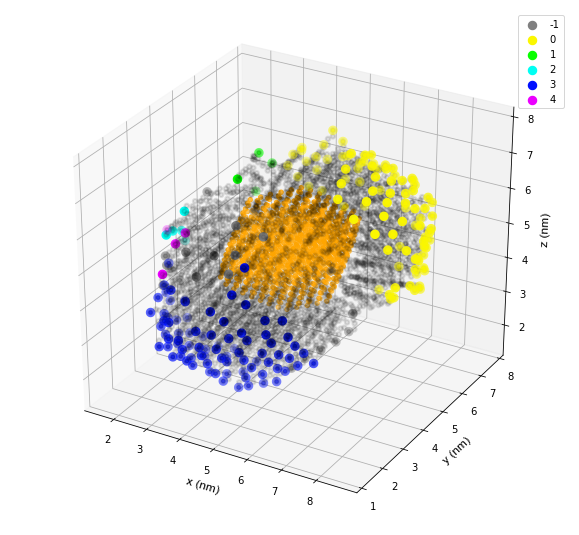

In [16]:
### COMBINING CONTRIBUTIONS OF DISTANCES AND ANGLES

### FUNCTION TO RESCALE VECTOR BETWEEN 0 AND 1
def rescale_vector(vec):
    '''
    The purpose of this function is to rescale a vector between 0 and 1
    INPUTS:
        vec: [np.array, shape=(N,1)] numpy array that you want to be normalized
    OUTPUTS:
        rescaled_vec: [np.array, shape=(N,1)] numpy array that has been rescaled between 0 and 1
    '''
    ## FINDING NEW VECTOR USING MINIMA AND MAXIMA
    rescaled_vec =  ( vec - np.min(vec) ) / (np.max(vec) - np.min(vec))
    return rescaled_vec

## START BY RESCALING
angle_btwn_rescaled = rescale_vector(angles_btwn)
distances_matrix_rescaled = rescale_vector(distances_matrix)

## DEFINING NEW FEATURE MATRIX
weights = [0.50, 0.50] # 50% / 50% weighted
feature_matrix = np.average( (angle_btwn_rescaled, distances_matrix_rescaled ), axis = 0, weights = weights)

## PRINTING FEATURE MATRIX
print("--- feature_matrix ---")
print(feature_matrix)

## RUNNING HDBSCAN AGAIN
## DEFINING MINIMUM NUMBER OF SAMPLES
min_samples = 3

## RUNNING DBSCAN CLUSTERING
labels = cluster_HDBSCAN( X = feature_matrix,
                         min_samples = min_samples,
                         metric='precomputed',
                         verbose = True
                        )
print("--- labels ---")
print(labels)

## FINDING UNIQUE ASSIGNEMTS
unique_assignments = np.unique(labels, return_counts=True)[0]

## FINDING TOTAL GROUPS
total_groups = len(unique_assignments)

print("\n--- unique_assignments ---")
print(unique_assignments)
print("Total groups: %d"%(total_groups) )

## PLOTTING HDBSCAN RESULTS
## PLOTTING END GROUPS
plot_order = ['AUNP', 'LIGAND']  # 'LIGAND' 'SULFURS'
## PLOTTING EACH               
fig, ax = plot_each_atom_index(positions = atom_positions, 
                                frame = 0,
                                plot_atom_index_dict = plot_atom_index_dict,
                                plot_order = plot_order)

## FINDING GROUP LIST
group_list = find_group_assignments(labels)

## PLOTTING ASSIGNMENTS
fig, ax = plot_assignments( positions = atom_positions,
                           atom_index = end_group_index,
                           group_list = group_list,
                           frame = 0,
                           fig = fig,
                           ax = ax,
                           **assignment_plot_dict
                          )